# Natural Language Processing with Disaster Tweets
## Our aim in this project is to predict which Tweets are about real disasters and which ones are not.
### Provided by : Sina Ainesazi Dovom

#### Importing the required packages

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from wordcloud import WordCloud
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sinaainesaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Preparation

### Loading the Data

In [65]:
train_df = pd.read_csv("train.csv", sep = ",")
test_df = pd.read_csv("test.csv", sep = ",")

In [66]:
# Checking on the dimension of the data and first 5 rows
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [67]:
# Checking to see if the dataset contains NaN values
train_df.isnull().any(axis=0)

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

The dataset that is used in this project, includes 7613 observations and 5 variables which are, ID, keyword, location, text, and target. Each tweet has an ID, a keyword variable that indicates the type of tweet, a location column that describes the place about which the tweet is about, and a text column containing the tweet's text and lastly, the target variable that consists of two values 0 and 1, which 0 has been assigned to the tweets which are not about a disaster but vice versa the number 1 has been assigned to the tweets which are about a disaster. Since the majority of the values for keyword and location columns were empty, and the ID variable does not have any useful information, these three columns have been dropped from the data set. The text variable itself contains all the required useful information, but the text data is in raw text which by itself, cannot be used as a feature. So it needs to be preprocessed.

#### Dropping some useless columns

In [68]:
# The id, keyword and location variables are not useful in this study so we drop them.
train_df = train_df.drop(columns = ["id", "keyword", "location"], axis=0)

In [69]:
# This is the final shape of the dataset we're going to use. Our focus is on the text variable.
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


#### Checking to see if data is balanced

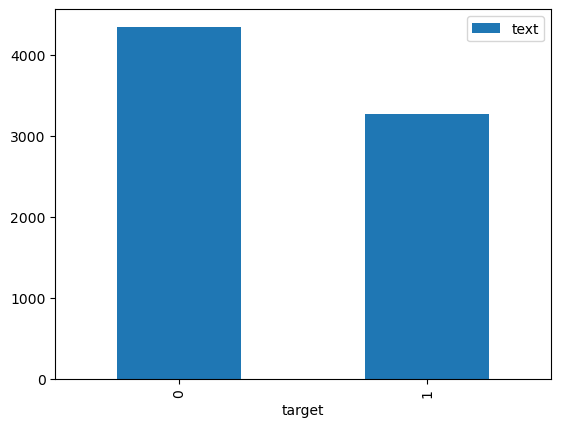

In [70]:
train_df.groupby("target").count().plot.bar(ylim=0)
plt.show()

It is evident that there are more occurrences of 0 than 1, in the target variable. Still, the good thing is that the difference is not significant and the data is relatively balanced. Before starting the preprocessing steps, the raw text should be examined to see what words are more frequent. The benefit of this is that it gives an idea of which words and signs are not helpful to use.

### Use of wordcloud to see which words are common

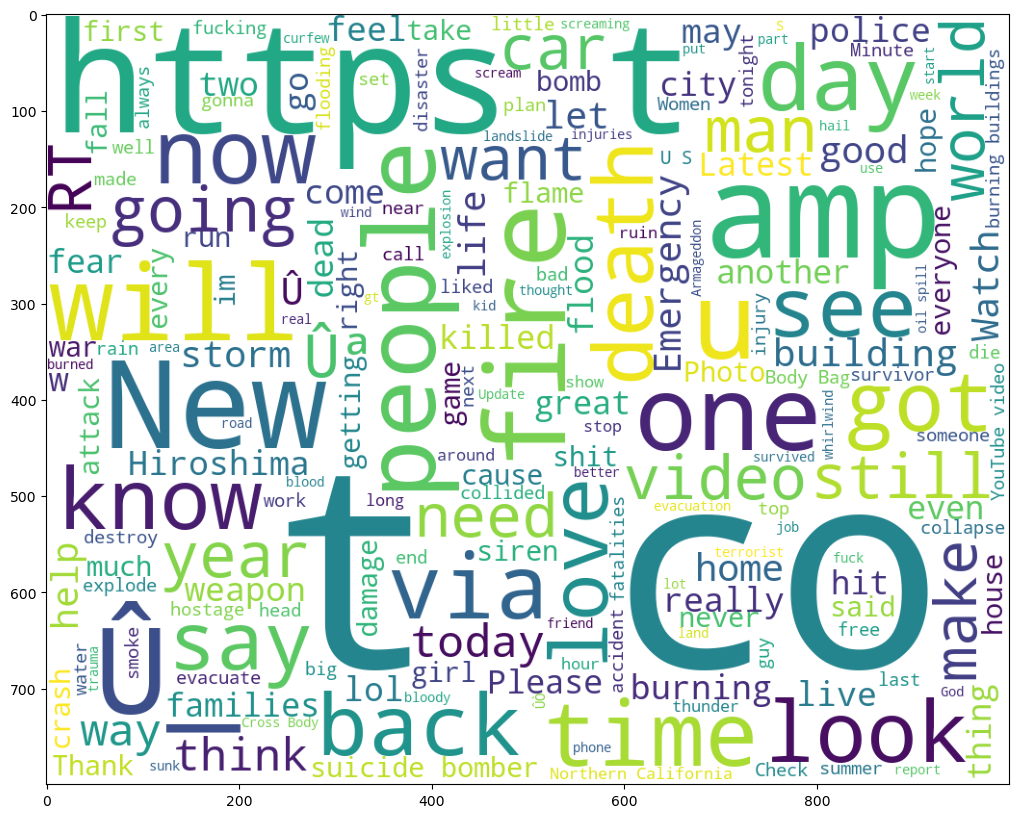

In [71]:
wordcloud = WordCloud(background_color="white",width=1000, height=800).generate(' '.join(train_df['text'].tolist()))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)

This is a useful plot showing the most common words have been appeared inside the text of the twitts in our dataset. we can see some words which have no specific meanings so considering them to drop from the text in the dataset would be a good idea.

The preprocessing steps which have been taken into account are Removing punctuation, Removing stopwords, Conversion to lower case, and Stemming, for fulfilling these steps the nltk
package has been loaded and used in this project.

## Preprocessing the raw text



In [72]:
stemmer = PorterStemmer()

In [73]:
# Using the stopwords that have been provided for the text in English.
words = stopwords.words("english")
# We're gonna extend the stopword list using the common words which seem to be not useful from the wordcloud plot
more_stop_words=["https","tco","co","via","s","rt","st","w","RT", "im","re","Û","û_https","m","û","d","v","a","b","c","e","f","g","h","lol","l","n","o","p","k","q","r","s","t","u","v","w","ll","ve","co","nt"]
words.extend(more_stop_words)

#### Adding a new column to the dataset with the preprocessed raw text and applying the usual tools used for NLP tasks on the text

In [74]:
train_df["processedtext"] = train_df["text"].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [75]:
# Comparing the raw and processed text to see the difference
train_df.head()
print(train_df["text"][0])
print(train_df["processedtext"][0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
our deed reason earthquak may allah forgiv us


#### Now we delete the raw text column from the data

In [76]:
del train_df["text"]

In [77]:
# adding the target column as a variable
target = train_df["target"]

### Splitting the data into train and validation data sets

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df["processedtext"], target, train_size = 0.75, random_state = 123)

In [79]:
# Checking on the dimensions
print(train_df.shape); print(X_train.shape); print(X_valid.shape)

(7613, 2)
(5709,)
(1904,)


After having done the preprocessing step, for building machine learning models, there is a need to convert the raw text to word frequency vectors. There are several ways to do this, such as using CountV ectorizer and HashingV ectorizer, but the TfidfVectorizer has been used in this task since it’s the most popular one and it is used as a weighting factor in text mining applications. In simple words, TF-IDF attempts to highlight important words which are frequent in a document but not across documents. By using TF-IDF, we are able to extract the important words from the corpus, reducing the data dimensions by removing words that are less important for analysis

### Vectorizing the data

In [80]:
# Using tfidf vectorizer on the training and validation sets
vectorizer_tfidf = TfidfVectorizer()

train_tfIdf = vectorizer_tfidf.fit_transform(X_train)

valid_tfIdf = vectorizer_tfidf.transform(X_valid)

In [18]:
print(train_tfIdf.shape); print(valid_tfIdf.shape)

(5709, 15535)
(1904, 15535)


# Building models and Using different methods to train the data

### Logistic Regression classifier

In [19]:
# Logistic regression is the most popular model in every classification tasks
classifier_LR = LogisticRegression()
classifier_LR.fit(train_tfIdf, y_train)

predLR_train = classifier_LR.predict(train_tfIdf) 
accuracy_LR_train = metrics.accuracy_score(y_train, predLR_train)
Conf_metrics_LR_train = metrics.confusion_matrix(y_train, predLR_train)

predLR_valid = classifier_LR.predict(valid_tfIdf) 
accuracy_LR_valid = metrics.accuracy_score(y_valid, predLR_valid)
Conf_metrics_LR_valid = metrics.confusion_matrix(y_valid, predLR_valid)

print(f"LogisticRegression.\tTraining Accuracy: {accuracy_LR_train}\tValidation Accuracy: {accuracy_LR_valid}")
print(f"Confusion matrix training:\n {Conf_metrics_LR_train}\nConfusion matrix valididation:\n {Conf_metrics_LR_valid}")

LogisticRegression.	Training Accuracy: 0.8957785952005605	Validation Accuracy: 0.7909663865546218
Confusion matrix training:
 [[3159   86]
 [ 509 1955]]
Confusion matrix valididation:
 [[951 146]
 [252 555]]


### Logistic Regression with different Hyperparameters

LogisticRegression. C= 0.001.	Training Accuracy: 0.5684007707129094	Validation Accuracy: 0.5761554621848739
LogisticRegression. C= 0.01.	Training Accuracy: 0.5684007707129094	Validation Accuracy: 0.5761554621848739
LogisticRegression. C= 0.1.	Training Accuracy: 0.7524960588544404	Validation Accuracy: 0.7473739495798319
LogisticRegression. C= 0.5.	Training Accuracy: 0.8661762129970223	Validation Accuracy: 0.7872899159663865
LogisticRegression. C= 1.0.	Training Accuracy: 0.8957785952005605	Validation Accuracy: 0.7909663865546218
LogisticRegression. C= 5.	Training Accuracy: 0.9642669469259064	Validation Accuracy: 0.7914915966386554
LogisticRegression. C= 10.	Training Accuracy: 0.9861622000350324	Validation Accuracy: 0.7909663865546218
LogisticRegression. C= 15.	Training Accuracy: 0.9905412506568576	Validation Accuracy: 0.7888655462184874
LogisticRegression. C= 20.	Training Accuracy: 0.9931686810299527	Validation Accuracy: 0.7857142857142857
LogisticRegression. C= 100.	Training Accuracy: 0

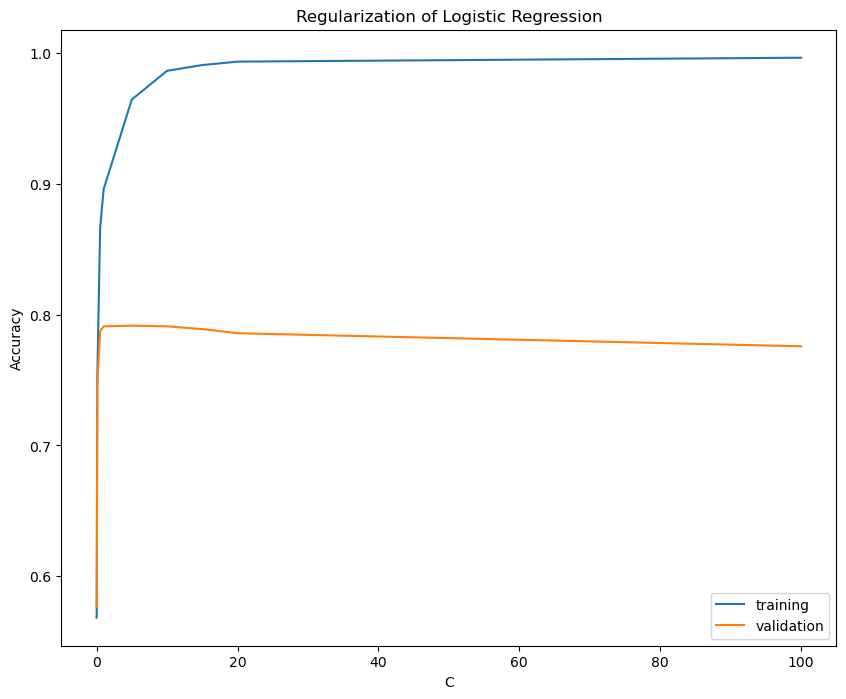

In [20]:
# Using regularization parameters to see the changes on the accuracies
C = [0.001, 0.01, 0.1, 0.5, 1., 5, 10, 15, 20, 100]
Training_Accuracy_LR_H = []
Validation_Accuracy_LR_H = []
for c in C:
    classifier_LR_H = LogisticRegression(C = c, max_iter = 200)
    classifier_LR_H.fit(train_tfIdf, y_train)

    predLR_H_train = classifier_LR_H.predict(train_tfIdf)
    accuracy_LR_H_train = metrics.accuracy_score(y_train, predLR_H_train)
    Training_Accuracy_LR_H.append(accuracy_LR_H_train)
    predLR_H_valid = classifier_LR_H.predict(valid_tfIdf)
    accuracy_LR_H_valid= metrics.accuracy_score(y_valid, predLR_H_valid)
    Validation_Accuracy_LR_H.append(accuracy_LR_H_valid)
    print(f"LogisticRegression. C= {c}.\tTraining Accuracy: {accuracy_LR_H_train}\tValidation Accuracy: {accuracy_LR_H_valid}")

fig = plt.figure(figsize=(10, 8))
plt.plot(C,Training_Accuracy_LR_H, label="training")
plt.plot(C,Validation_Accuracy_LR_H, label="validation")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Regularization of Logistic Regression")
plt.legend()
plt.show()

#### It seems that adding hyperparameters for the logistic regression is not a good idea. Since the simple model without hyperparameters is having 89% accuracy on the training dataset and 79% on the validation set. but as we use higher values for regularization parameter the accuracy on the training dataset is increasing to the 99% but on the other hand it has the low accuracy on the validation set which shows we're overfitting the data.

### Random Forest Classifier

In [21]:
# Using random forest classifier with entropy as criterion
classifier_RF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 123)
classifier_RF.fit(train_tfIdf, y_train)

predRF_train = classifier_RF.predict(train_tfIdf) 
accuracy_RF_train = metrics.accuracy_score(y_train, predRF_train)
Conf_metrics_RF_train = metrics.confusion_matrix(y_train, predRF_train)

predRF_valid = classifier_RF.predict(valid_tfIdf) 
accuracy_RF_valid = metrics.accuracy_score(y_valid, predRF_valid)
Conf_metrics_RF_valid = metrics.confusion_matrix(y_valid, predRF_valid)

print(f"RandomForestClassifier.\tTraining Accuracy: {accuracy_RF_train}\tValidation Accuracy: {accuracy_RF_valid}")
print(f"Confusion matrix training:\n {Conf_metrics_RF_train}\nConfusion matrix valididation:\n {Conf_metrics_RF_valid}")

RandomForestClassifier.	Training Accuracy: 0.9735505342441758	Validation Accuracy: 0.7857142857142857
Confusion matrix training:
 [[3233   12]
 [ 139 2325]]
Confusion matrix valididation:
 [[990 107]
 [301 506]]


#### well it's obvious that this model is also overfitting the data since it has a good performance on predicting the training values but it does not have a good accuracy on the validation set in comparison to the training set.

### K Nearest Neighbor Classifier

KNeighborsClassifier. K= 1.	Training Accuracy: 0.9956209493781748	Validation Accuracy: 0.7205882352941176
KNeighborsClassifier. K= 2.	Training Accuracy: 0.8444561219127693	Validation Accuracy: 0.743172268907563
KNeighborsClassifier. K= 3.	Training Accuracy: 0.8626729724995621	Validation Accuracy: 0.7473739495798319
KNeighborsClassifier. K= 4.	Training Accuracy: 0.8274654055000876	Validation Accuracy: 0.7641806722689075
KNeighborsClassifier. K= 5.	Training Accuracy: 0.8395515852163251	Validation Accuracy: 0.7599789915966386
KNeighborsClassifier. K= 6.	Training Accuracy: 0.8181818181818182	Validation Accuracy: 0.773109243697479
KNeighborsClassifier. K= 7.	Training Accuracy: 0.8286915396741986	Validation Accuracy: 0.7746848739495799
KNeighborsClassifier. K= 8.	Training Accuracy: 0.8159047118584691	Validation Accuracy: 0.7757352941176471
KNeighborsClassifier. K= 9.	Training Accuracy: 0.8220353827290243	Validation Accuracy: 0.7788865546218487
KNeighborsClassifier. K= 10.	Training Accuracy: 

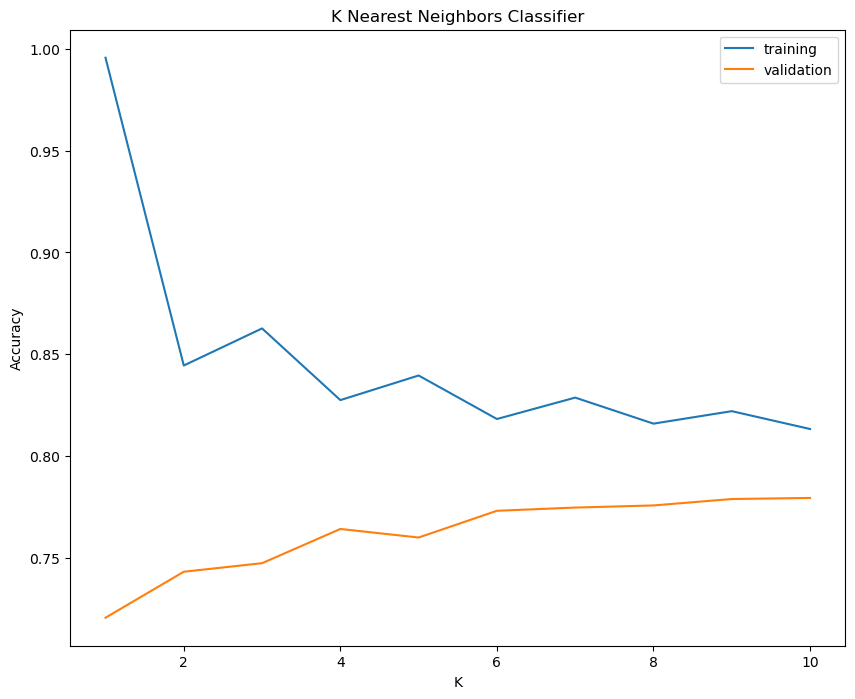

In [22]:
# Using KNN as another model on the data with 10 K's to see the performance
K = range(1, 11)
Training_Accuracy_KNN = []
Validation_Accuracy_KNN = []

for k in K:
    classifier_KNN = KNeighborsClassifier(n_neighbors=k)
    classifier_KNN.fit(train_tfIdf, y_train)

    predKNN_train = classifier_KNN.predict(train_tfIdf)
    accuracy_KNN_train = metrics.accuracy_score(y_train, predKNN_train)
    Training_Accuracy_KNN.append(accuracy_KNN_train)

    predKNN_valid = classifier_KNN.predict(valid_tfIdf)
    accuracy_KNN_valid= metrics.accuracy_score(y_valid, predKNN_valid)
    Validation_Accuracy_KNN.append(accuracy_KNN_valid)
    print(f"KNeighborsClassifier. K= {k}.\tTraining Accuracy: {accuracy_KNN_train}\tValidation Accuracy: {accuracy_KNN_valid}")
    
fig = plt.figure(figsize=(10, 8))
plt.plot(K, Training_Accuracy_KNN, label="training")
plt.plot(K, Validation_Accuracy_KNN, label="validation")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("K Nearest Neighbors Classifier")
plt.legend()
plt.show()

#### As we know, KNN with low K has overfitting problem and with high K has underfitting problem. In out case it seems that as the value of K goes beyond 6 there's no huge increase on the accuracy of the validation set and this number seems to be a reasonable value that balances between overfitting and underfitting. However, we can use cross-validation to check on more values for K.

### Support Vector Machine with linear function and C = 1

In [23]:
# SVM is another popular learning algorithm being used. Here we use this method using linear kernel.
classifier_SVM = SVC(kernel = 'linear', random_state = 123, C = 1)
classifier_SVM.fit(train_tfIdf, y_train)
predSVM_train = classifier_SVM.predict(train_tfIdf)
accuracy_SVM_train = metrics.accuracy_score(y_train, predSVM_train)
Conf_metrics_SVM_train = metrics.confusion_matrix(y_train, predSVM_train)

predSVM_valid = classifier_SVM.predict(valid_tfIdf)
accuracy_SVM_valid = metrics.accuracy_score(y_valid, predSVM_valid)
Conf_metrics_SVM_valid = metrics.confusion_matrix(y_valid, predSVM_valid)

print(f"SupportVectorMachine.\tTraining Accuracy: {accuracy_SVM_train}\tValidation Accuracy: {accuracy_SVM_valid}")
print(f"Confusion matrix training:\n {Conf_metrics_SVM_train}\nConfusion matrix valididation:\n {Conf_metrics_SVM_valid}")

SupportVectorMachine.	Training Accuracy: 0.9358906988964792	Validation Accuracy: 0.8004201680672269
Confusion matrix training:
 [[3171   74]
 [ 292 2172]]
Confusion matrix valididation:
 [[943 154]
 [226 581]]


### Support Vector Machine with rbf function and different values for constant C

In [24]:
C = [0.1, 1., 1.5, 10]
for c in C :
  classifier_SVM_rbf = SVC(kernel = 'rbf', random_state = 123, C = c)
  classifier_SVM_rbf.fit(train_tfIdf, y_train)
  predSVM_rbf_train = classifier_SVM_rbf.predict(train_tfIdf)
  accuracy_SVM_rbf_train = metrics.accuracy_score(y_train, predSVM_rbf_train)
  predSVM_rbf_valid = classifier_SVM_rbf.predict(valid_tfIdf)
  accuracy_SVM_rbf_valid = metrics.accuracy_score(y_valid, predSVM_rbf_valid)
  print(f"SupportVectorMachine with C= {c}.\tTraining Accuracy: {accuracy_SVM_rbf_train}\tValidation Accuracy: {accuracy_SVM_rbf_valid}")

SupportVectorMachine with C= 0.1.	Training Accuracy: 0.5871431073743213	Validation Accuracy: 0.604516806722689
SupportVectorMachine with C= 1.0.	Training Accuracy: 0.9728498861446838	Validation Accuracy: 0.7977941176470589
SupportVectorMachine with C= 1.5.	Training Accuracy: 0.9889647924330005	Validation Accuracy: 0.7983193277310925
SupportVectorMachine with C= 10.	Training Accuracy: 0.9963215974776668	Validation Accuracy: 0.7930672268907563


### By now, we have seen how different methods are performing on our dataset. Now it's time to use Neural Networks in our study and see how useful is it.

# Neural Network

In [115]:
count_vectorizer2 = CountVectorizer()
X_train_nn = count_vectorizer2.fit_transform(train_df.processedtext)
X_train_nn = pd.DataFrame(X_train_nn.toarray())

In [116]:
# Configuration options
labels = set(y_train)
print(labels, len(labels))

# Configuration options
feature_vector_length = X_train_nn.shape[1] #how many features
num_classes = len(labels) #how many classes
print(feature_vector_length)
print(num_classes)

{0, 1} 2
18957
2


In [117]:
#convert to one-hot encoding representation the ground truth
y_train_nn = to_categorical(target, num_classes)

In [121]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', #quantity to be monitored
                   mode='min', #we look for decreasing patterns stop 
                   patience = 10, #number of epochs with no improvement
                   verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                189580    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 22        
Total params: 189,602
Trainable params: 189,602
Non-trainable params: 0
_________________________________________________________________
None


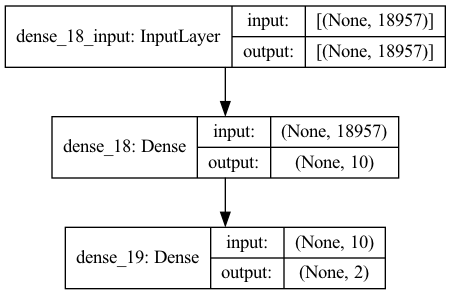

In [122]:
np.random.seed(123)
set_random_seed(2)

model_NN1 = Sequential() #we first define how the "model" looks like
model_NN1.add(Dense(input_dim = feature_vector_length, units=10 , activation='relu')) #input layer
model_NN1.add(Dense(num_classes, activation='softmax')) #output layer
print(model_NN1.summary())
plot_model(model_NN1, show_shapes= True)

We now train our model.
During our training, we use several epochs, meaning that our model saw more times the same training samples.
When using more epochs, it is important to look at the training curve, i.e., we print the loss (or accuracy) of both training and validation at the varying of the epochs.
This plot can tell us a lot about the trained model, such as: Is there any underfitting / overfitting problem? How is then training curve shape?

Epoch 1/50
357/357 [==============================] - 1s 3ms/step - loss: 0.6783 - accuracy: 0.5718 - val_loss: 0.6477 - val_accuracy: 0.5977
Epoch 2/50
357/357 [==============================] - 1s 2ms/step - loss: 0.6280 - accuracy: 0.6700 - val_loss: 0.6166 - val_accuracy: 0.6602
Epoch 3/50
357/357 [==============================] - 1s 2ms/step - loss: 0.5821 - accuracy: 0.7345 - val_loss: 0.5987 - val_accuracy: 0.6770
Epoch 4/50
357/357 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7658 - val_loss: 0.5669 - val_accuracy: 0.7342
Epoch 5/50
357/357 [==============================] - 1s 2ms/step - loss: 0.5053 - accuracy: 0.8032 - val_loss: 0.5479 - val_accuracy: 0.7468
Epoch 6/50
357/357 [==============================] - 1s 2ms/step - loss: 0.4824 - accuracy: 0.8059 - val_loss: 0.5403 - val_accuracy: 0.7369
Epoch 7/50
357/357 [==============================] - 1s 2ms/step - loss: 0.4547 - accuracy: 0.8175 - val_loss: 0.5253 - val_accuracy: 0.7537
Epoch 

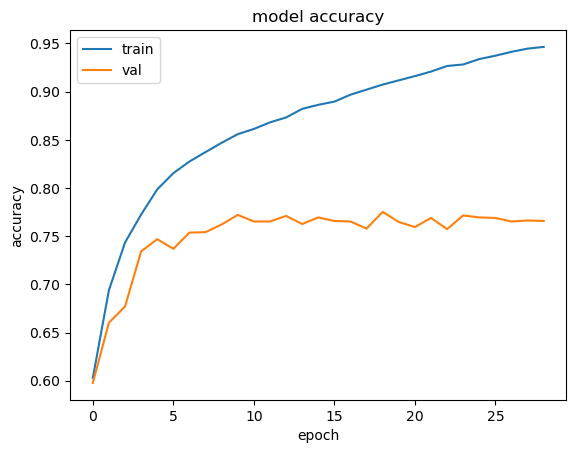

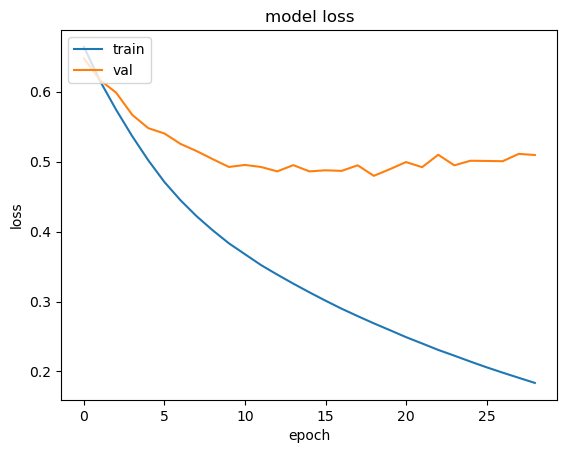

In [123]:
# Configure the model and start training
model_NN1.compile(loss='categorical_crossentropy',  # loss metric
              optimizer='sgd',  # optimizer
              metrics=['accuracy'])  # displayed metric

history=model_NN1.fit(X_train_nn, y_train_nn, epochs=50, batch_size=16, verbose=1, validation_split=0.25, callbacks=[es])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We defined the patience value in earlystoppings equal to 10. And according to that the training stopped at epoch 29. We're having 0.94 as the training accuracy and 0.76 as the validation accuracy. According to accuracy plot as the value of epoch goes beyond 10 there's no such a good improvement on the validation accuracy.and the loss function plot shows that after 10th epoch the loss for the validation set is starting to increase. So if we consider the results of the 10th epoch as best performing results we see the accuracy of 85% for the training set and 77% for the validation set. which shows an acceptable fit on the data.

# Preparaing the Test data set and Vectorizing it

In [124]:
test_df = test_df.drop(columns = ["id", "keyword", "location"], axis=0)
test_df["processedtext"] = test_df["text"].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
del test_df["text"]
test_tfIdf = vectorizer_tfidf.transform(test_df["processedtext"])

# Prediction on test data set with the used algorithms

In [125]:
sample_submission_LR = pd.read_csv("https://www.math.unipd.it/~dasan/disaster/sample_submission.csv", sep = ",")
sample_submission_LR["target"] = classifier_LR.predict(test_tfIdf)
sample_submission_LR.to_csv("submission_LR.csv", index=False)

In [126]:
final_LR_H = LogisticRegression(C = 1, max_iter = 200)
final_LR_H.fit(train_tfIdf, y_train)
sample_submission_LR_H = pd.read_csv("https://www.math.unipd.it/~dasan/disaster/sample_submission.csv", sep = ",")
sample_submission_LR_H["target"] = final_LR_H.predict(test_tfIdf)
sample_submission_LR_H.to_csv("submission_LR_H.csv", index=False)

In [127]:
sample_submission_RF = pd.read_csv("https://www.math.unipd.it/~dasan/disaster/sample_submission.csv", sep = ",")
sample_submission_RF["target"] = classifier_RF.predict(test_tfIdf)
sample_submission_RF.to_csv("submission_RF.csv", index=False)

In [128]:
final_KNN = KNeighborsClassifier(n_neighbors=10)
final_KNN.fit(train_tfIdf, y_train)
sample_submission_KNN = pd.read_csv("https://www.math.unipd.it/~dasan/disaster/sample_submission.csv", sep = ",")
sample_submission_KNN["target"] = classifier_KNN.predict(test_tfIdf)
sample_submission_KNN.to_csv("submission_KNN.csv", index=False)

In [129]:
sample_submission_SVM = pd.read_csv("https://www.math.unipd.it/~dasan/disaster/sample_submission.csv", sep = ",")
sample_submission_SVM["target"] = classifier_SVM.predict(test_tfIdf)
sample_submission_SVM.to_csv("submission_SVM.csv", index=False)

In [130]:
final_SVM_rbf = SVC(kernel = 'rbf', random_state = 123, C = 1.)
final_SVM_rbf.fit(train_tfIdf, y_train)
sample_submission_SVM_rbf = pd.read_csv("https://www.math.unipd.it/~dasan/disaster/sample_submission.csv", sep = ",")
sample_submission_SVM_rbf["target"] = final_SVM_rbf.predict(test_tfIdf)
sample_submission_SVM_rbf.to_csv("submission_SVM_rbf.csv", index=False)

From the results of all the methods, it was concluded that the support vector machine algorithm with RBF function and C = 1 had the best accuracy and result on the test set of all the methods used. And we received a good ranking of the submission on the Kaggle website.
After all, I did my best to have a good job in preprocessing phase of this study which in my opinion, this step is the most important step after having understood the problem in data science projects. This can be proved by comparing the the same text in both preprocessed and raw text in the dataset. The different methods have been used and they all had similar results and we did not observe such a huge difference comparing them to each other. I was expecting to achieve the best result in Neural Network part but since I am still learning the Deep Learning principles, I am pretty sure that I will gain a better knowledge in the close future and be able to implement a better network to receive the best result.